In [60]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import seaborn as sns

# STA365 Homework 3

## Sizhang Lyu

First, we import the data. I am using the classical Kaggle house pricing data.

Source: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/My Drive/house-prices-advanced-regression-techniques 2/train.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


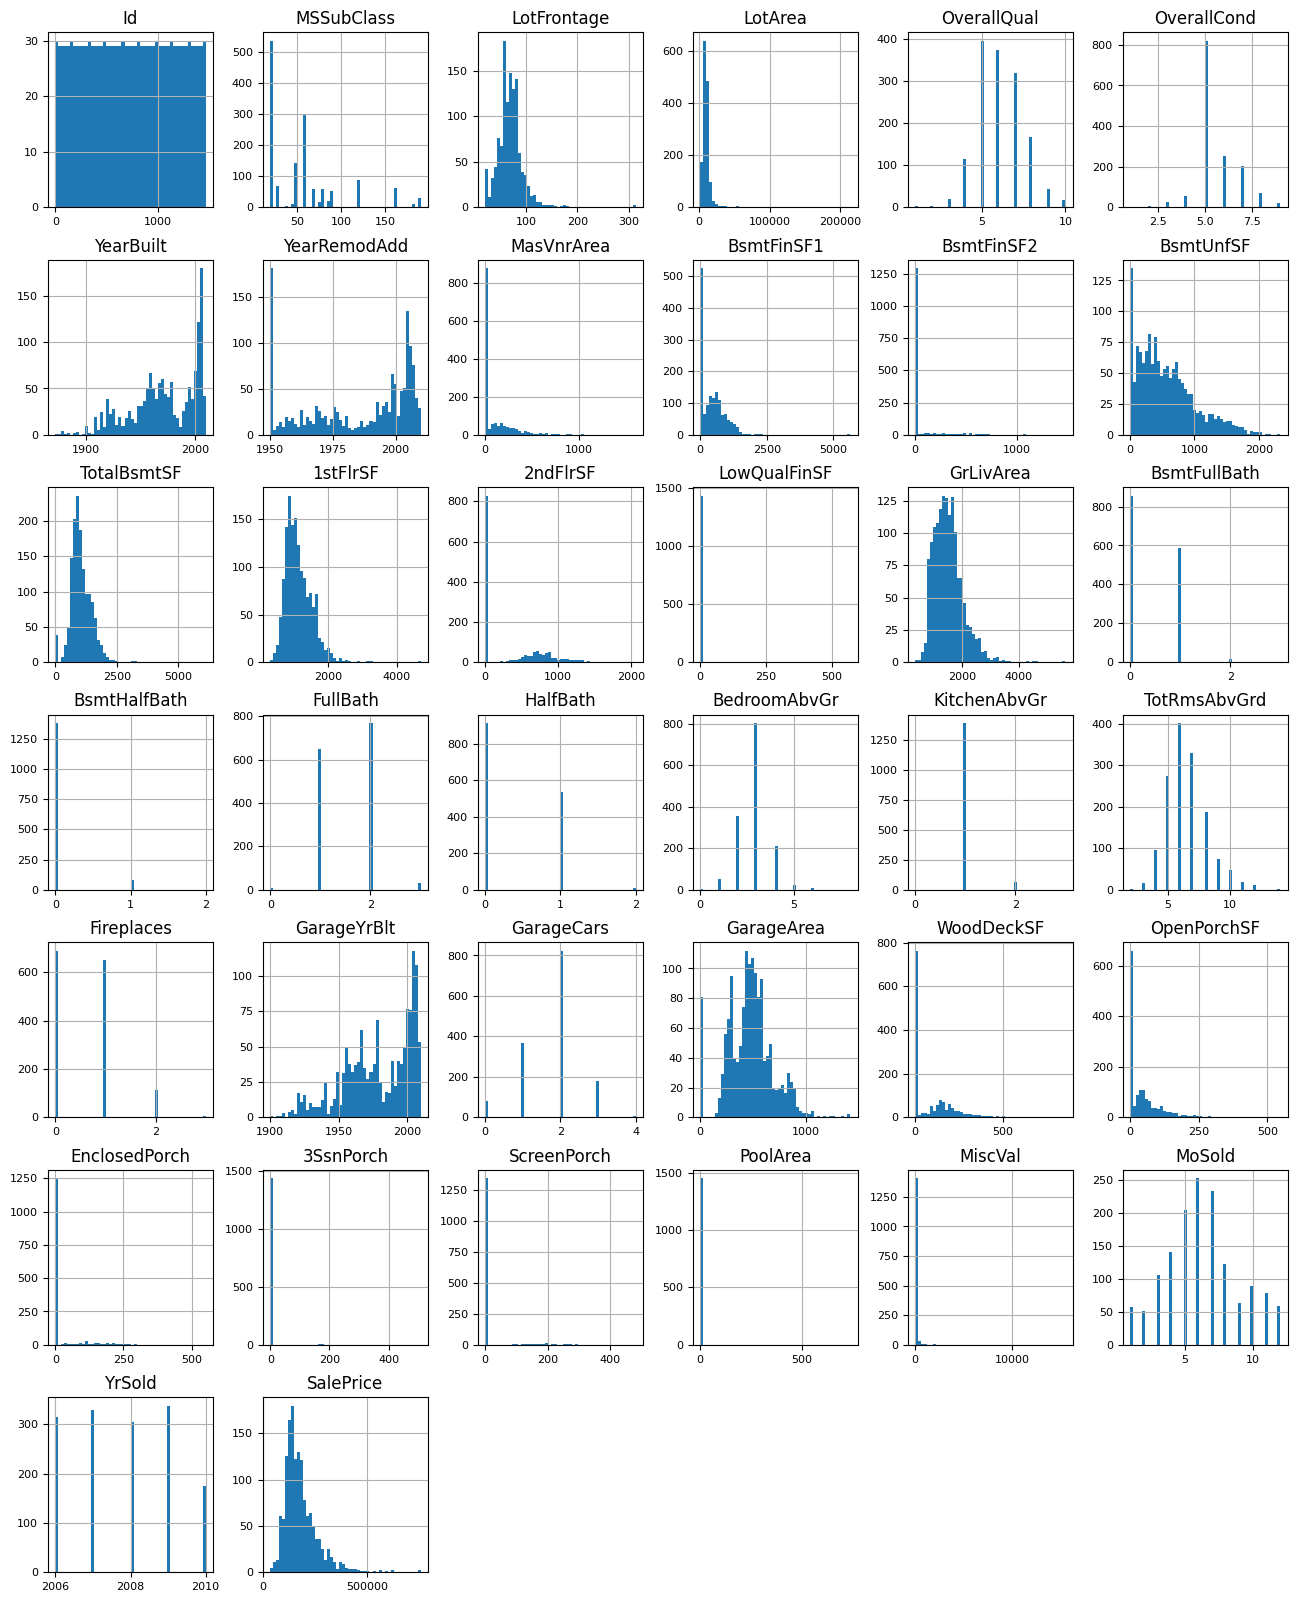

In [9]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

It looks like column `1stFlrSF` is approximately normally distributed and column `SalePrice` is skewed (thus non-normal), so I will choose these two columns to complete the tasks.

In [10]:
normal_column = df['1stFlrSF']
nonnormal_column = df['SalePrice']

Now apply the normal-gamma model on the normal column, choosing the prior based on observation and sample statistics

In [22]:
np.mean(normal_column)

1162.626712328767

In [23]:
np.std(normal_column)

386.45532230228963

In [49]:
normal_gamma_model = pm.Model()
with normal_gamma_model:
    theta = pm.Normal("theta", mu = 1000, sigma = 100)
    sigma = pm.Gamma("sigma", alpha = 40, beta = 10)
    x_obs = pm.Normal("likelihood", mu = theta, sigma = sigma, observed = normal_column)
    idata_HMC = pm.sample(3000, chains = 4)

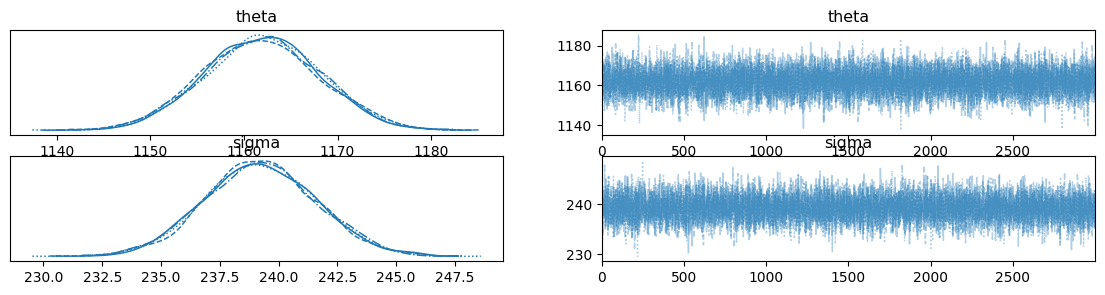

In [50]:
fig,ax = plt.subplots(2,2, figsize=(14,3))
az.plot_trace(idata_HMC, axes=ax)
plt.show()

Autocorrelation for HMC (MCMC) chain -0.002955253788022861


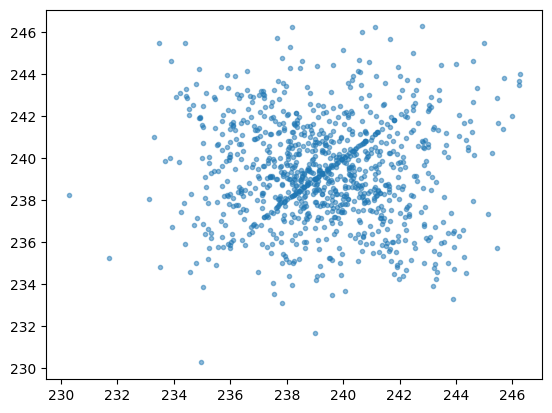

In [52]:
max_mcmc_samples = 1000
mcmc_chain = idata_HMC.posterior["sigma"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values
mcmc_chain_one_step_ahead = idata_HMC.posterior["sigma"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values
plt.plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

In [54]:
print("number of MCMC samples:", idata_HMC.posterior['sigma'].values.flatten().shape[-1])
az.summary(idata_HMC, round_to = 3)

number of MCMC samples: 12000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,1161.922,6.189,1150.669,1173.698,0.055,0.039,12585.621,8632.501,1.001
sigma,239.222,2.376,234.875,243.788,0.021,0.015,12922.258,9019.241,1.000


The model seems to work well! All 4 chains appear to converge, the samples are relatively stable, the autocorrelation is weakly negative, and the effective sample size is large. The computed 97% highest density interval for $\theta$ is [1150.67, 1173.7], and the computed 97% highest density interval for $\sigma$ is [234.88, 243.79].

Now let's apply a different model specification for the non-normal column. I will assume a log-normal likelihood based on my observation.

Text(0.5, 1.0, 'Q-Q Plot of Log(SalePrice)')

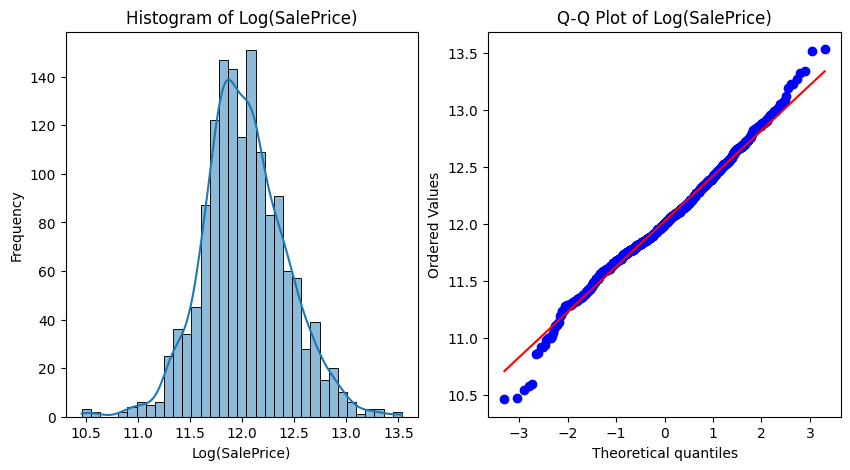

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(np.log(nonnormal_column), kde=True, ax=ax[0])
ax[0].set_title('Histogram of Log(SalePrice)')
ax[0].set_xlabel('Log(SalePrice)')
ax[0].set_ylabel('Frequency')
stats.probplot(np.log(nonnormal_column), dist="norm", plot=ax[1])
ax[1].set_title('Q-Q Plot of Log(SalePrice)')

In [63]:
np.log(np.mean(nonnormal_column))

12.105816833620844

In [64]:
np.log(np.std(nonnormal_column)

11.282446221715093

In [83]:
nonnormal_model = pm.Model()
with nonnormal_model:
    mu = pm.Normal("mu", mu = 10, sigma = 10)
    sigma = pm.Gamma("sigma", alpha = 5, beta = 2)
    x_obs = pm.LogNormal("likelihood", mu = mu, sigma = sigma, observed = nonnormal_column)
    idata_HMC_2 = pm.sample(3000, chains = 4)

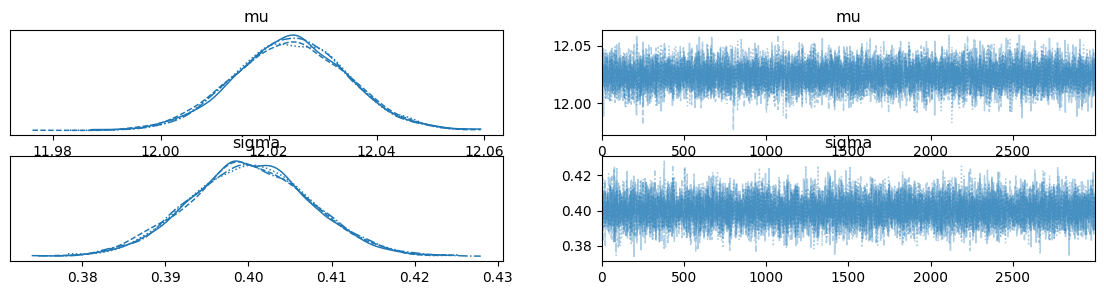

In [84]:
fig, ax = plt.subplots(2,2, figsize=(14,3))
az.plot_trace(idata_HMC_2, axes=ax)
plt.show()

Autocorrelation for HMC (MCMC) chain -0.019769931930336892


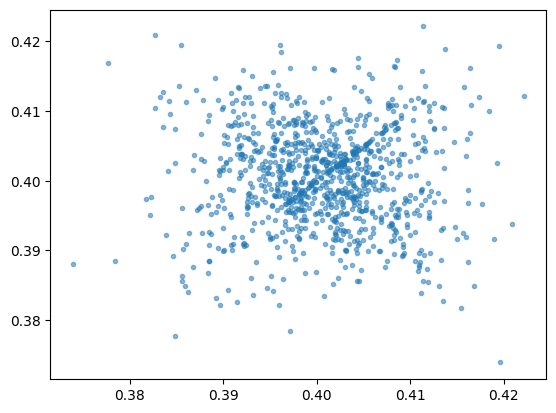

In [85]:
max_mcmc_samples = 1000
mcmc_chain = idata_HMC_2.posterior["sigma"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values
mcmc_chain_one_step_ahead = idata_HMC_2.posterior["sigma"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values
plt.plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])

In [87]:
print("number of MCMC samples:", idata_HMC_2.posterior['sigma'].values.flatten().shape[-1])
az.summary(idata_HMC_2, round_to = 3)

number of MCMC samples: 12000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,12.024,0.010,12.004,12.044,0.0,0.0,12807.164,8850.373,1.0
sigma,0.400,0.007,0.386,0.414,0.0,0.0,12696.946,8525.803,1.0


Again, the model seems to work well! All 4 chains appear to converge, the samples are relatively stable, the autocorrelation is weakly negative, and the effective sample size is large. The computed 97% highest density interval for  𝜃  is [12.004, 12.044], and the computed 97% highest density interval for  𝜎  is [0.386, 0.414].